# CIFAR10-KERAS-NN

The following script executes a program for picture recognition on the CIFAR-10 dataset using keras neural networks

In [1]:
### Packages
from datetime import datetime
import time
import os

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# https://stackoverflow.com/questions/3899980/how-to-change-the-font-size-on-a-matplotlib-plot
SMALL_SIZE = 16
MEDIUM_SIZE = 20
BIGGER_SIZE = 22
plt.rc('font', size=MEDIUM_SIZE)            # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)        # fontsize of the axes title
plt.rc('axes', labelsize=SMALL_SIZE)        # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)       # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)       # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)     # fontsize of the figure title

# Dataset
from keras.datasets import cifar10

# Subroutines
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D
import keras_tuner as kt
from sklearn.metrics import confusion_matrix

# Additional configurations, @see config.py
import config

### Configurations
# Training-Size
num_train = config.num_train                   # 60000 for full data set 
num_test  = config.num_test                    # 10000 for full data set

2022-09-19 21:33:47.552591: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-19 21:33:47.699683: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-09-19 21:33:47.699719: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-09-19 21:33:47.728051: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-09-19 21:33:48.423377: W tensorflow/stream_executor/platform/de

In [2]:
# Simple functions to log information
path = os.getcwd()+"/log"
logDir = os.path.exists(path)
if not logDir:
    os.makedirs(path)

plots = os.getcwd()+"/log/plots"
logDir = os.path.exists(plots)
if not logDir:
    os.makedirs(plots)

training_results = path+"/keras-nn-training-log.txt"
def log_training_results(*s):
    with open(training_results, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

hyperparameter_search_log = path+"/keras-nn-hyperparameter-tuning-log.txt"
def log_hyperparameter_search(*s):
    with open(hyperparameter_search_log, 'a') as f:
        for arg in s:
            print(arg, file=f)
            print(arg)

print("Generated data will be located in ", training_results, hyperparameter_search_log)
print("Generated plots will be located in ", plots)

log_training_results("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))
if config.hyper_parameter_search:
    log_hyperparameter_search("[%s] on (%s, %s) using (Train: %s, Test: %s)" % (datetime.now(), config.os, config.cpu, config.num_train, config.num_test))



Generated data will be located in  /home/thauer/GitProjects/CIFAR10_Benchmark/src/log/keras-nn-training-log.txt /home/thauer/GitProjects/CIFAR10_Benchmark/src/log/keras-nn-hyperparameter-tuning-log.txt
Generated plots will be located in  /home/thauer/GitProjects/CIFAR10_Benchmark/src/log/plots
[2022-09-19 21:33:49.236626] on (Linux-5.15.0-46-generic-x86_64-with-glibc2.29, x86_64) using (Train: 12500, Test: 2500)
[2022-09-19 21:33:49.236907] on (Linux-5.15.0-46-generic-x86_64-with-glibc2.29, x86_64) using (Train: 12500, Test: 2500)


In [3]:
# Fetch CIFAR10-Data from Keras repository
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
print("\t\t\t\t (Sets,  X,  Y, RGB)")
print("Shape of training data:\t\t", X_train.shape)
print("Shape of training labels:\t", y_train.shape)
print("Shape of testing data:\t\t", X_test.shape)
print("Shape of testing labels:\t", y_test.shape)

				 (Sets,  X,  Y, RGB)
Shape of training data:		 (50000, 32, 32, 3)
Shape of training labels:	 (50000, 1)
Shape of testing data:		 (10000, 32, 32, 3)
Shape of testing labels:	 (10000, 1)


/home/thauer/.local/lib/python3.8/site-packages/matplotlib/text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


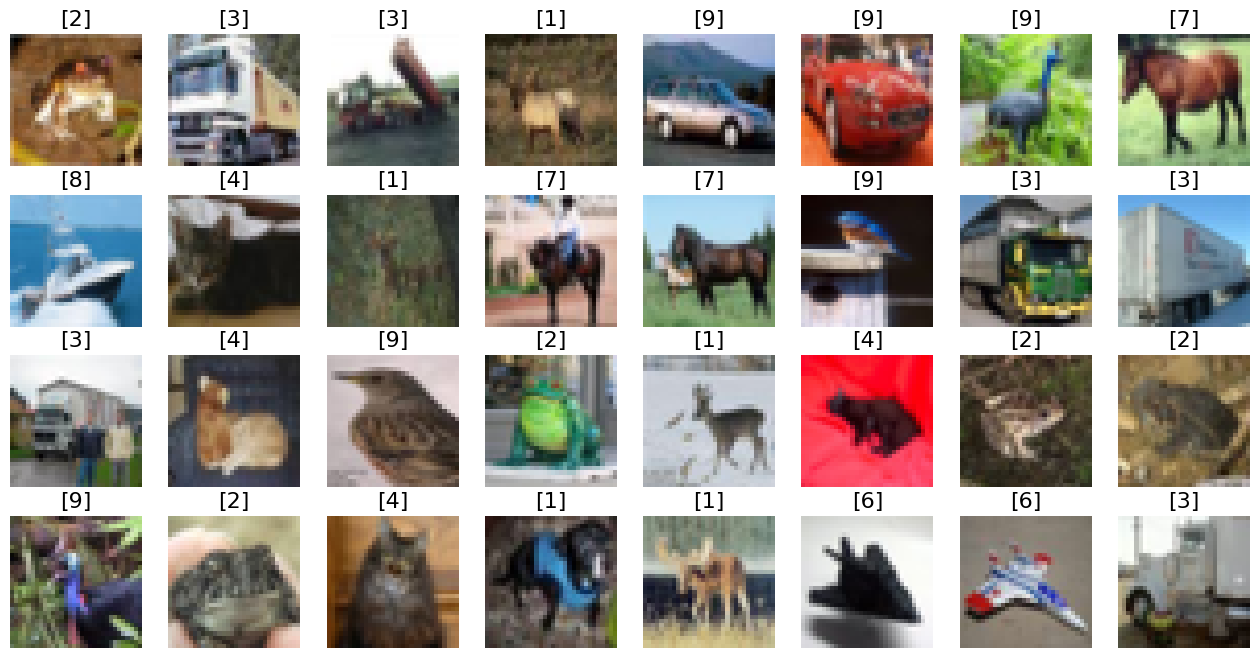

In [5]:
# Visualize some examples
cols=8
rows=4
fig, ax = plt.subplots(ncols=cols, nrows=rows, figsize=(cols*2, rows*2))
index = 0
for i in range(rows):
    for j in range(cols):
        ax[i,j].imshow(X_train[index])
        ax[i,j].set_title(y_train[y_train[index][0]], fontsize=16)
        ax[i,j].imshow(X_train[index])
        ax[i,j].axis('off')
        index += 1
plt.show()
fig.savefig(plots+'/cifar10_examples.png')


In [6]:
train_data = X_train
train_label = y_train
test_data = X_test
test_label = y_test

In [7]:
# Reshape the data such that we have access to every pixel of the image
train_data = X_train.astype('float32')
train_label = y_train.astype("float32")
test_data = X_test.astype('float32')
test_label = y_test.astype("float32")


In [8]:
# We know the RGB color code where different values produce various colors. It is also difficult to remember every color combination. 
# We already know that each pixel has its unique color code and also we know that it has a maximum value of 255. 
# To perform Machine Learning, it is important to convert all the values from 0 to 255 for every pixel to a range of values from 0 to 1.
train_data = train_data / 255
test_data = test_data / 255

In [9]:
# Categorize the labels by conversion from integers to a class matrix
train_label = keras.utils.to_categorical(train_label, config.num_classes)
test_label = keras.utils.to_categorical(test_label, config.num_classes)

In [10]:
# As an optional step, we decrease the training and testing data size, such that the algorithms perform their execution in acceptable time
train_data = train_data[1:num_train,]
train_label = train_label[1:num_train]

test_data = test_data[1:num_test,]
test_label = test_label[1:num_test]

In [11]:
print("\t\t\t\t (Sets,  X, Y, RGB )")
print("Reshaped training data:\t\t", train_data.shape)
print("Reshaped training labels:\t", train_label.shape)
print("Reshaped testing data:\t\t", test_data.shape)
print("Reshaped testing labels:\t", test_label.shape)

				 (Sets,  X, Y, RGB )
Reshaped training data:		 (12499, 32, 32, 3)
Reshaped training labels:	 (12499, 10)
Reshaped testing data:		 (2499, 32, 32, 3)
Reshaped testing labels:	 (2499, 10)


# Sequential Neural Network Model

Groups layers into a Tensorflow-defined neural network and provides interfaces for training and inference.

For more information, see: https://keras.io/api/models/sequential/


In [12]:
# Create model: https://keras.io/guides/sequential_model/
model = Sequential()

# First convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 

# Second convolutional layer
model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

# Max pooling layer
model.add(MaxPooling2D(pool_size=(2, 2))) 
model.add(Dropout(0.25)) 

# Flatten input into feature vector and feed into dense layer
model.add(Flatten()) 
model.add(Dense(units=config.num_of_units, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(units=config.num_of_units, activation='relu'))
model.add(Dropout(0.5))

# Outputs from dense layer are projected onto 10 unit output layer
model.add(Dense(units=config.num_classes, activation="softmax"))

# Compile model
optimizer = keras.optimizers.RMSprop(
    learning_rate=0.0001,
    epsilon = 1e-6,
)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 32)        9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 15, 15, 32)        0         
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 256)               1843456   
                                                        

2022-09-19 21:33:52.026949: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-09-19 21:33:52.026977: W tensorflow/stream_executor/cuda/cuda_driver.cc:263] failed call to cuInit: UNKNOWN ERROR (303)
2022-09-19 21:33:52.026999: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (warmachine): /proc/driver/nvidia/version does not exist
2022-09-19 21:33:52.027233: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
# Train model
start_time = time.time()
history = model.fit(
    x=train_data, 
    y=train_label, 
    batch_size=config.batch_size, 
    epochs=config.num_epochs, 
    shuffle=True, 
    validation_data=(test_data, test_label))
end_time = time.time() - start_time

params = {"Keras":{"batch_size":config.batch_size, "epochs":config.num_epochs}}
log_training_results("--- [%s] Trained new model: %s in %s seconds ---" % (datetime.now(), params, end_time))

Epoch 1/8
391/391 [==============================] - 15s 35ms/step - loss: 2.1610 - accuracy: 0.1905 - val_loss: 1.9541 - val_accuracy: 0.3337
Epoch 2/8
391/391 [==============================] - 14s 35ms/step - loss: 1.9354 - accuracy: 0.2831 - val_loss: 1.7713 - val_accuracy: 0.3709
Epoch 3/8
391/391 [==============================] - 14s 35ms/step - loss: 1.7880 - accuracy: 0.3446 - val_loss: 1.6306 - val_accuracy: 0.4418
Epoch 4/8
391/391 [==============================] - 14s 35ms/step - loss: 1.6889 - accuracy: 0.3748 - val_loss: 1.5336 - val_accuracy: 0.4590
Epoch 5/8
391/391 [==============================] - 14s 35ms/step - loss: 1.5989 - accuracy: 0.4160 - val_loss: 1.4922 - val_accuracy: 0.4742
Epoch 6/8
391/391 [==============================] - 14s 35ms/step - loss: 1.5364 - accuracy: 0.4418 - val_loss: 1.4716 - val_accuracy: 0.4762
Epoch 7/8
391/391 [==============================] - 14s 36ms/step - loss: 1.4780 - accuracy: 0.4598 - val_loss: 1.3886 - val_accuracy: 0.5046

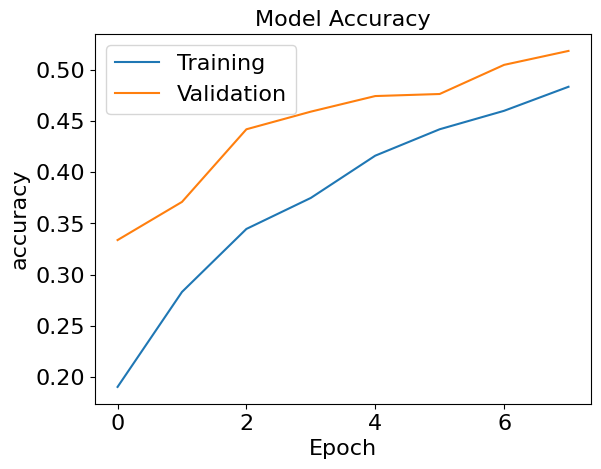

In [14]:
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig(plots+'/training_history_standard.png')


In [15]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(train_data, train_label)
end_time = time.time() - start_time

log_training_results("\tPredicting train data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))  

391/391 [==============================] - 2s 6ms/step - loss: 1.2577 - accuracy: 0.5499
	Predicting train data -- Execution time: 2.4620325565338135s; Accuracy: 0.5498839616775513; Loss: 1.2576926946640015


In [16]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label)
end_time = time.time() - start_time

log_training_results("\tPredicting test data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))

79/79 [==============================] - 0s 6ms/step - loss: 1.3336 - accuracy: 0.5182
	Predicting test data -- Execution time: 0.5171761512756348s; Accuracy: 0.518207311630249; Loss: 1.333624243736267


In [17]:
# Let model predict data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

79/79 [==============================] - 0s 5ms/step


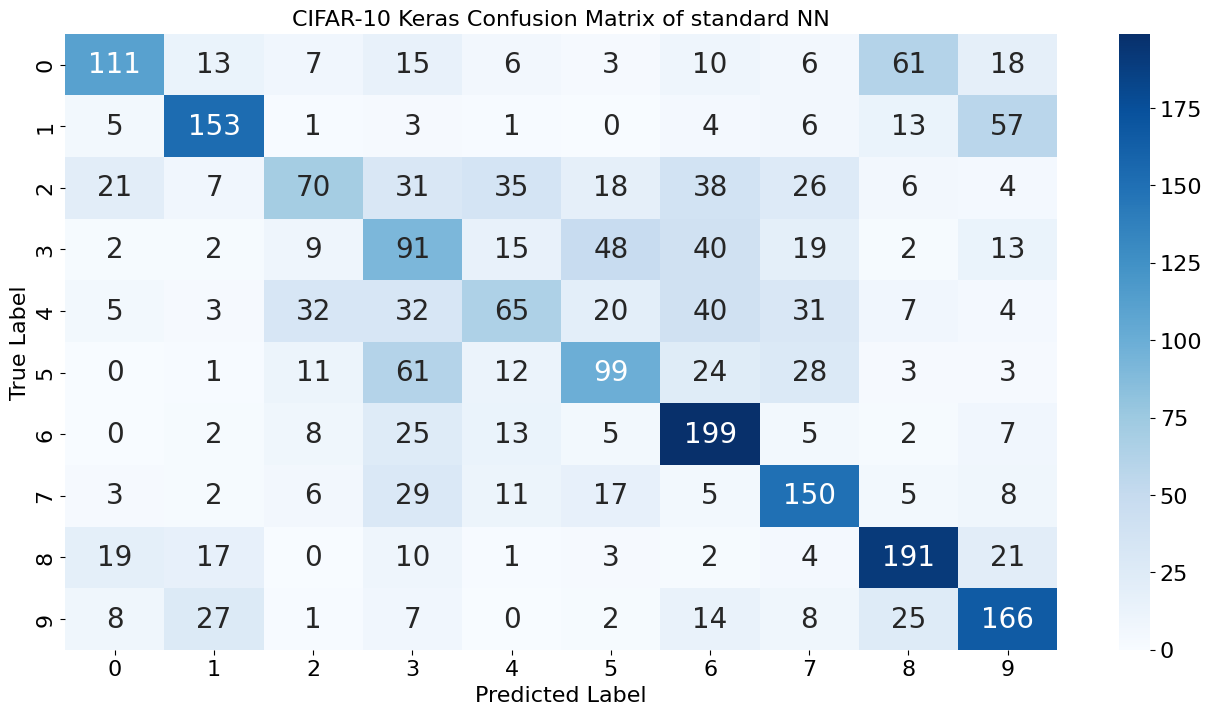

In [18]:
# Visualize estimation over correct and incorrect prediction via confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CIFAR-10 Keras Confusion Matrix of standard NN')
plt.show()
fig.savefig(plots+'/ConfusionMatrix_standard.png')

In [19]:
if not config.hyper_parameter_search:
    print("Terminating without hyperparameter search.")
    exit(0)
print("Starting hyperparameter search over %s epochs each" % (config.hps_max_epochs))

Starting hyperparameter search over 24 epochs each


## Hyperparameter evaluation

The search utilizes the keras_tuner library. The model_builder defines the layout and parametrization which are utilized by the different search algorithms further below. 

What can be tuned:
- Dropout: If dropout happens & dropout rate
- Convolutionals: Filters
- Dense: Units
- All: Activation functions

Also see: https://keras.io/api/keras_tuner/

In [20]:
def model_builder(hp):
    hp_units = hp.Int('units', min_value=32, max_value=512, step=32)
    hp_activation = hp.Choice('activation', ['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5])
    hp_dropout = hp.Boolean("dropout")
    hp_dropout_rate = hp.Float('dropout-rate', min_value=0.25, max_value=0.50, step=0.05)

    model = keras.Sequential()
    
    # First convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32,32,3), activation='relu', padding='same')) 

    # Second convolutional layer
    model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu'))

    # Max pooling layer

    model.add(MaxPooling2D(pool_size=(2, 2))) 

    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))

    # Flatten input into feature vector and feed into dense layer
    model.add(Flatten()) 
    model.add(Dense(units=hp_units, activation=hp_activation))
    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))
        
    #model.add(Dense(units=config.num_of_units, activation='relu'))
    model.add(Dense(units=hp_units, activation=hp_activation))
    if hp_dropout:
        model.add(Dropout(rate=hp_dropout_rate))
    # Outputs from dense layer are projected onto 10 unit output layer
    model.add(Dense(units=config.num_classes, activation="softmax"))

    # Compile model
    optimizer = keras.optimizers.RMSprop(
        learning_rate=hp_learning_rate,
        epsilon = 1e-6,
    )

    #model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

### Random Search

See: https://keras.io/api/keras_tuner/tuners/random/

In [21]:
tuner = kt.RandomSearch(
    model_builder,
    objective='val_accuracy',
    #max_epochs=config.max_trials,
    #factor=3,                    
    directory='log/hps',
    project_name='keras-hyperparameter-search-RandomSearch'
)

In [22]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
csvlogger = keras.callbacks.CSVLogger(hyperparameter_search_log, separator=",", append=True)
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-RandomSearch] ---" % datetime.now())
best_hps_rs = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("Best parameters set found on following development set: %s" % best_hps_rs.values)

best_hps_rs_results = tuner.results_summary(num_trials=1)

best_hps_rs_model = tuner.get_best_models(num_models=1)[0]
rs_test_loss, rs_test_acc = best_hps_rs_model.evaluate(test_data, test_label)
log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (rs_test_loss, rs_test_acc))  

Trial 10 Complete [00h 01m 00s]
val_accuracy: 0.10480000078678131

Best val_accuracy So Far: 0.5996000170707703
Total elapsed time: 00h 33m 47s
INFO:tensorflow:Oracle triggered exit


--- [2022-09-19 22:09:37.573936] Running Parameter-Tests [Keras-RandomSearch] ---
Best parameters set found on following development set: {'units': 288, 'activation': 'tanh', 'learning_rate': 0.0001, 'dropout': False, 'dropout-rate': 0.3}
Results summary
Results in log/hps/keras-hyperparameter-search-RandomSearch
Showing 1 best trials
Trial summary
Hyperparameters:
units: 288
activation: tanh
learning_rate: 0.0001
dropout: False
dropout-rate: 0.3
Score: 0.5996000170707703
79/79 [==============================] - 1s 7ms/step - loss: 1.2449 - accuracy: 0.5794
	Predicting test data -- Accuracy: 1.2448982000350952; Loss: 0.5794317722320557


### Bayesian Optimiziation

See: https://keras.io/api/keras_tuner/tuners/bayesian/

In [23]:
tuner = kt.BayesianOptimization(
    model_builder,
    objective='val_accuracy',
    max_trials=config.hps_max_trials,
    #factor=3,                    
    directory='log/hps',
    project_name='keras-hyperparameter-search-BayesianOptimization'
)

In [24]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
csvlogger = keras.callbacks.CSVLogger(hyperparameter_search_log, separator=",", append=True)
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-BayesianOptimization] ---" % datetime.now())
best_hps_bo = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("Best parameters set found on following development set: %s" % best_hps_bo.values)

best_hps_bo_results = tuner.results_summary(num_trials=1)

best_hps_bo_model = tuner.get_best_models(num_models=1)[0]
bo_test_loss, bo_test_acc = best_hps_bo_model.evaluate(test_data, test_label)
log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (bo_test_loss, bo_test_acc))  

Trial 16 Complete [00h 01m 48s]
val_accuracy: 0.10639999806880951

Best val_accuracy So Far: 0.5867999792098999
Total elapsed time: 00h 40m 07s
INFO:tensorflow:Oracle triggered exit
--- [2022-09-19 22:49:45.599350] Running Parameter-Tests [Keras-BayesianOptimization] ---
Best parameters set found on following development set: {'units': 128, 'activation': 'relu', 'learning_rate': 0.0001, 'dropout': False, 'dropout-rate': 0.49999999999999994}
Results summary
Results in log/hps/keras-hyperparameter-search-BayesianOptimization
Showing 1 best trials
Trial summary
Hyperparameters:
units: 128
activation: relu
learning_rate: 0.0001
dropout: False
dropout-rate: 0.49999999999999994
Score: 0.5867999792098999
79/79 [==============================] - 1s 4ms/step - loss: 1.2158 - accuracy: 0.5778
	Predicting test data -- Accuracy: 1.2158178091049194; Loss: 0.5778311491012573


#### Hyperband

See: https://keras.io/api/keras_tuner/tuners/hyperband/


In [25]:
tuner = kt.Hyperband(
    model_builder,
    objective='val_accuracy',
    max_epochs=config.hps_max_trials,
    factor=3,                    
    directory='log/hps',
    project_name='keras-hyperparameter-search-Hyperband'
)


In [26]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3, verbose=1)
csvlogger = keras.callbacks.CSVLogger(hyperparameter_search_log, separator=",", append=True)
tuner.search(
    train_data,
    train_label,
    epochs=config.hps_max_epochs,
    validation_split=0.2,
    callbacks=[stop_early]
)

log_hyperparameter_search("--- [%s] Running Parameter-Tests [Keras-Hyperband] ---" % datetime.now())
best_hps_hb = tuner.get_best_hyperparameters(num_trials=1)[0]
log_hyperparameter_search("Best parameters set found on following development set: %s" % best_hps_hb.values)

best_hps_hb_results = tuner.results_summary(num_trials=1)

best_hps_hb_model = tuner.get_best_models(num_models=1)[0]
hb_test_loss, hb_test_acc = best_hps_hb_model.evaluate(test_data, test_label)
log_hyperparameter_search("\tPredicting test data -- Accuracy: %s; Loss: %s" % (hb_test_loss, hb_test_acc))  

Trial 30 Complete [00h 01m 27s]
val_accuracy: 0.4392000138759613

Best val_accuracy So Far: 0.6043999791145325
Total elapsed time: 00h 24m 16s
INFO:tensorflow:Oracle triggered exit
--- [2022-09-19 23:14:02.685221] Running Parameter-Tests [Keras-Hyperband] ---
Best parameters set found on following development set: {'units': 416, 'activation': 'relu', 'learning_rate': 0.001, 'dropout': True, 'dropout-rate': 0.44999999999999996, 'tuner/epochs': 16, 'tuner/initial_epoch': 6, 'tuner/bracket': 1, 'tuner/round': 1, 'tuner/trial_id': '0022'}
Results summary
Results in log/hps/keras-hyperparameter-search-Hyperband
Showing 1 best trials
Trial summary
Hyperparameters:
units: 416
activation: relu
learning_rate: 0.001
dropout: True
dropout-rate: 0.44999999999999996
tuner/epochs: 16
tuner/initial_epoch: 6
tuner/bracket: 1
tuner/round: 1
tuner/trial_id: 0022
Score: 0.6043999791145325
79/79 [==============================] - 0s 4ms/step - loss: 1.1573 - accuracy: 0.6158
	Predicting test data -- Accur

## Hyperparameter search analytics

Now utilize the 'best' algorithm (weight based on accuracy) and train a new model with the most optimal parameters.

In [27]:
# Map and print the scores
accuracy_score = {"RandomSearch": rs_test_acc, "BayesianOptimization": bo_test_acc, "HyperBand": hb_test_acc}
loss_score = {"RandomSearch": rs_test_loss, "BayesianOptimization": bo_test_loss, "HyperBand": hb_test_loss}

print("--- Finalized scores ")
print("\tAccuracy: %s" % accuracy_score)
print("\tLoss: %s" % loss_score)

--- Finalized scores 
	Accuracy: {'RandomSearch': 0.5794317722320557, 'BayesianOptimization': 0.5778311491012573, 'HyperBand': 0.6158463358879089}
	Loss: {'RandomSearch': 1.2448982000350952, 'BayesianOptimization': 1.2158178091049194, 'HyperBand': 1.1573175191879272}


In [28]:
# Choose the best model out of all three based on accuracy
# For Loss, it is required to adjust the score here and the values taken for the diagrams below.
# Tip: Search ''accuracy'' and replace
best_accuracy = max(accuracy_score, key=accuracy_score.get)
print("Algorithm: %s" % best_accuracy)

best_accuracy_value = max(accuracy_score.values())
print("Score: %s" % best_accuracy_value)

model = 0
if best_accuracy == "RandomSearch":
    model = tuner.hypermodel.build(best_hps_rs)
elif best_accuracy == "BayesianOptimization":
    model = tuner.hypermodel.build(best_hps_bo)
elif best_accuracy == "HyperBand":
    model = tuner.hypermodel.build(best_hps_hb)


Algorithm: HyperBand
Score: 0.6158463358879089


### Optimal Model Fitting

Train the most-optimal model the algorithm could come up with.

In [29]:
# Train a new model with the optimal algorithm and parameters
start_time = time.time()
history = model.fit(
    x=train_data, 
    y=train_label, 
    batch_size=config.batch_size, 
    epochs=config.num_epochs, 
    shuffle=True, 
    validation_data=(test_data, test_label)
)
end_time = time.time() - start_time
params = {"HPS-Opt-Keras":{"batch_size":config.batch_size, "epochs":config.num_epochs}}
log_training_results("--- [%s] Trained new model: %s in %s seconds ---" % (datetime.now(), params, end_time))

Epoch 1/8
391/391 [==============================] - 12s 29ms/step - loss: 1.8213 - accuracy: 0.3320 - val_loss: 1.4593 - val_accuracy: 0.4750
Epoch 2/8
391/391 [==============================] - 11s 29ms/step - loss: 1.4579 - accuracy: 0.4797 - val_loss: 1.2988 - val_accuracy: 0.5454
Epoch 3/8
391/391 [==============================] - 11s 29ms/step - loss: 1.2794 - accuracy: 0.5548 - val_loss: 1.1993 - val_accuracy: 0.5726
Epoch 4/8
391/391 [==============================] - 11s 29ms/step - loss: 1.1425 - accuracy: 0.6054 - val_loss: 1.3866 - val_accuracy: 0.5442
Epoch 5/8
391/391 [==============================] - 11s 29ms/step - loss: 1.0533 - accuracy: 0.6389 - val_loss: 1.1360 - val_accuracy: 0.6022
Epoch 6/8
391/391 [==============================] - 11s 29ms/step - loss: 0.9761 - accuracy: 0.6681 - val_loss: 1.0734 - val_accuracy: 0.6130
Epoch 7/8
391/391 [==============================] - 11s 29ms/step - loss: 0.9179 - accuracy: 0.6911 - val_loss: 1.1332 - val_accuracy: 0.6150

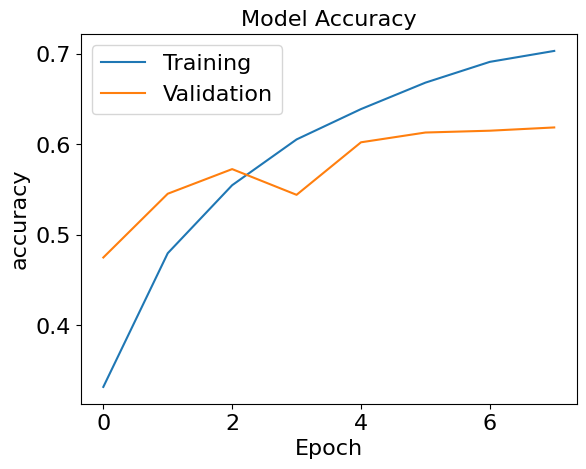

In [30]:
# Display Accuracy
fig = plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()
fig.savefig(plots+'/training_history_optimal.png')

# When a machine learning model has high training accuracy and very low validation then this case is probably known as over-fitting. The reasons for this can be as follows:
#    The hypothesis function you are using is too complex that your model perfectly fits the training data but fails to do on test/validation data.
#    The number of learning parameters in your model is way too big that instead of generalizing the examples , your model learns those examples and hence the model performs badly on test/validation data.

In [31]:
start_time = time.time()
test_loss, test_acc = model.evaluate(train_data, train_label)
end_time = time.time() - start_time
log_training_results("\tPredicting train data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))  

391/391 [==============================] - 2s 4ms/step - loss: 0.5559 - accuracy: 0.8253
	Predicting train data -- Execution time: 1.9360599517822266s; Accuracy: 0.825346052646637; Loss: 0.5559049248695374


In [32]:
# Evaluate model based on supplied tags
start_time = time.time()
test_loss, test_acc = model.evaluate(test_data, test_label)
end_time = time.time() - start_time

log_training_results("\tPredicting test data -- Execution time: %ss; Accuracy: %s; Loss: %s" % (end_time, test_acc, test_loss))  

79/79 [==============================] - 0s 4ms/step - loss: 1.1100 - accuracy: 0.6186
	Predicting test data -- Execution time: 0.39240550994873047s; Accuracy: 0.6186474561691284; Loss: 1.1099543571472168


In [33]:
# Let model predict data
y_pred = model.predict(test_data)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(test_label, axis=1)

79/79 [==============================] - 0s 4ms/step


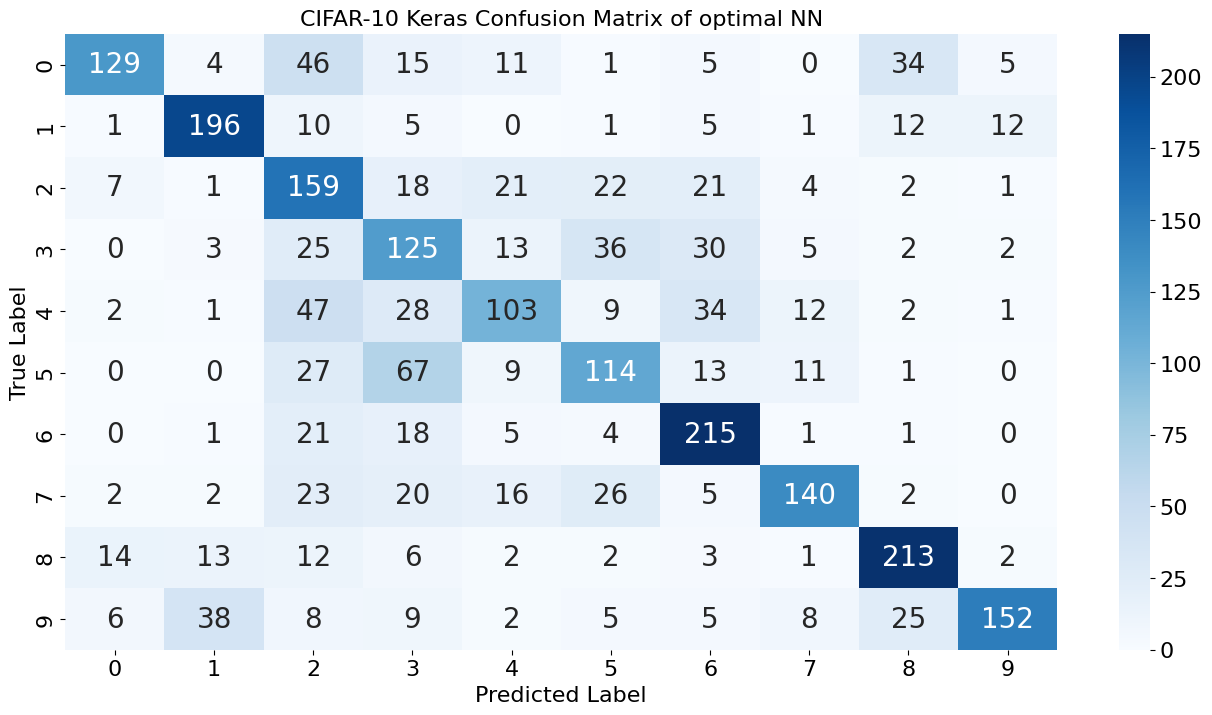

In [34]:
# Visualize estimation over correct and incorrect prediction via confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(16,8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt='d', ax=ax, cmap="Blues")
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_title('CIFAR-10 Keras Confusion Matrix of optimal NN')
plt.show()
fig.savefig(plots+'/ConfusionMatrix_optimal.png')